This notebook performs the construction of the GME-based, non-Markovian Model for the alanine dipeptide system. The model is built upon featurized trajectories. To manage time constraints, we eliminate two steps here: cross-validation to determine the hyperparameters to construct microstate-MSM and boostrapping to validate microstate-MSM.

In [3]:
# @title Install packages and download the necessary files (takes about 1 min)
# !pip install msmbuilder2022
# python >= 3.12 this is not necessary
# !pip install numpy==1.23.5
# %pip install matplotlib
# !curl -L https://uwmadison.box.com/shared/static/xemwq0f2mbpob19el6xxlvca8gl45f9v --output ftrajs.npy
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/quasi-MSM/qmsm.py
!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/IGME/igme.py



--2024-10-27 22:30:38--  https://github.com/xuhuihuang/GME_tutorials/raw/main/quasi-MSM/qmsm.py
github.com (github.com) 해석 중... 140.82.113.3
다음으로 연결 중: github.com (github.com)|140.82.113.3|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 302 Found
위치: https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/quasi-MSM/qmsm.py [따라감]
--2024-10-27 22:30:38--  https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/quasi-MSM/qmsm.py
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 12116 (12K) [text/plain]
저장 위치: `qmsm.py'

qmsm.py             100%[===================>]  11.83K  --.-KB/s    /  0s      

2024-10-27 22:30:39 (31.9 MB/s) - `qmsm.py' 저장함 [12116/12116]

--2024-10-27 22:30:39--  https://github.com/xuhuihuang/GME_tutorials/raw/main/IGME/igme.py
github.com (github.com) 해

In [1]:
# @title Import necessary packages
import sys
import numpy as np
from matplotlib import pyplot as plt

from msmbuilder.decomposition import tICA
from msmbuilder.msm import MarkovStateModel
from msmbuilder.cluster import KMeans, MiniBatchKMeans, KCenters
from msmbuilder.lumping import PCCAPlus

from igme import IGMENS, IGME
from qmsm import QuasiMSM, MSM

/Users/happyjack/Desktop/GME_tutorials/tutorials/igme.py:5: SyntaxWarning: invalid escape sequence '\h'
  """ Integrative Generalized Master Equation (IGME)
/Users/happyjack/Desktop/GME_tutorials/tutorials/igme.py:125: SyntaxWarning: invalid escape sequence '\h'
  """ Integrative Generalized Master Equation
/Users/happyjack/Desktop/GME_tutorials/tutorials/igme.py:229: SyntaxWarning: invalid escape sequence '\d'
  """ Construct an IGME model based on the input data
/Users/happyjack/Desktop/GME_tutorials/tutorials/igme.py:403: SyntaxWarning: invalid escape sequence '\d'
  """ Construct an IGME model based on the input data
/Users/happyjack/Desktop/GME_tutorials/tutorials/igme.py:453: SyntaxWarning: invalid escape sequence '\d'
  """ Scan IGME models within the given range of lagtime
/Users/happyjack/Desktop/GME_tutorials/tutorials/igme.py:542: SyntaxWarning: invalid escape sequence '\h'
  """Find the median model, closest to the average ln\hat{T}
/Users/happyjack/Desktop/GME_tutorials/tu

In [3]:
# @title tICA: dimensionality reduction

# Load the featurized trajectories
ftrajs = np.load('ftrajs.npy', allow_pickle=True)

# Use tICA for dimensionality reduction
tica = tICA(n_components=3, lag_time=2, kinetic_mapping=True)
tica_trajs = tica.fit_transform(ftrajs)
'''
Users can adjust these parameters in a demand-driven way:

n_components: int
    Number of collective variables (tICs) to generate
lag_time: int
    Delay time forward in the input data, in the unit of a saving interval.
    The time-lagged correlations is computed between datas X[t] and X[t+lag_time].
kinetic_mapping: bool
    If True, weigh the projections by the tICA eigenvalues, yielding kinetic distances.
'''

print("The dimension of the featurized trajectories is: %d"%ftrajs[0].shape[1])
print("The dimension of the trajectories after tICA is: %d"%tica_trajs[0].shape[1])

The dimension of the featurized trajectories is: 45
The dimension of the trajectories after tICA is: 3


In [5]:
# @title K-Centers: geometric clustering (takes about 2 min)
cluster = KCenters(n_clusters=800, random_state=42)
clustered_trajs = cluster.fit_transform(tica_trajs)
'''
Users can adjust these parameters in a demand-driven way:

n_clusters: int
    The number of clusters to form.
random_state:
    The generator used to initialize the centers. Not necessary.
'''

print("The trajectories are transformed as transitions between states:")
print(clustered_trajs[0])

# The cluster centers for K-Centers are interpretable.
print("\nThe coordinates of the centers in the tIC-space are")
print(cluster.cluster_centers_)

The trajectories are transformed as transitions between states:
[591 256 280 ... 685 123 123]

The coordinates of the centers in the tIC-space are
[[-0.65924523 -1.28813233 -0.70789292]
 [ 1.10560715 -4.67021509  4.11656021]
 [-0.01784652 -1.26333114  2.9965923 ]
 ...
 [-0.35303571 -0.32715995  2.45335035]
 [ 0.86284801 -1.6702547  -0.79513062]
 [ 0.05650248 -3.42427968  2.38421549]]


In [6]:
# @title Construct the microstate-MSM
# at lag time = 10ps
'''
We eliminate the validation of microstate-MSM due to time restrictions.
More details can be found on GitHub: https://github.com/xuhuihuang/GME_tutorials
'''
msm = MarkovStateModel(n_timescales=10, lag_time=100, ergodic_cutoff='off',
                       reversible_type='transpose', verbose=False)
msm.fit(clustered_trajs)
'''
Users can adjust these parameters in a demand-driven way:

lag_time: int
    The lag time of the model, in the unit of a saving interval.
n_timescales: int
    The number of dynamical timescales to calculate.
reversible_type: {'mle', 'transpose'}
    Method by which the reversibility of the transition matrix is enforced.
    'mle' uses a maximum likelihood method.
    'transpose' uses direct symmetrization of the expected number of counts.
ergodic_cutoff: float or {'on', 'off'}
    Ergodicity is determined by ensuring that each state is accessible from
    each other state via one or more paths involving edges with a number
    of observed directed counts greater than or equal to ``ergodic_cutoff``.
    By setting ``ergodic_cutoff`` to 0 or 'off', this trimming is turned off.
    Setting it to 'on' sets the cutoff to the minimal possible count value.
sliding_window : bool
    If True (the default setting), count transitions using a window of length lag_time,
    which is slid along the sequences one unit at a time. This method yields
    transitions that contain more data but cannot be assumed to be statistically independent.
    If False, the sequences are simply subsampled at an interval of ``lag_time``.
'''

# Attributes
micro_TCM = msm.countsmat_ # TCM
micro_TPM = msm.transmat_ # TPM
micro_population = msm.populations_ # Stationary Population Density
micro_timescales = msm.timescales_ # The ITS for the top modes, in the unit of a saving interval

delta_t = 0.1 # in unit of ps
print("The timescales of the top 10 modes for the microstate model are")
print(micro_timescales * delta_t)

The timescales of the top 10 modes for the microstate model are
[1142.5052904    60.56903762   20.0235938     4.39141287    4.17196569
    3.87271846    3.65747306    3.60817147    3.58355858    3.54656022]


In [7]:
# @title PCCA+: Kinetic lumping
n_macro = 4
msm = MarkovStateModel(n_timescales=10, lag_time=10, reversible_type='transpose',
                       verbose=False, ergodic_cutoff='off')
msm.fit(clustered_trajs)
pcca = PCCAPlus.from_msm(msm, n_macrostates=n_macro)
lumped_trajs = pcca.fit_transform(clustered_trajs)
'''
Users can adjust these parameters in a demand-driven way:

n_macrostates: int
    The number of the metastable states.
'''

/opt/anaconda3/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


Optimization terminated successfully.
         Current function value: -3.899448
         Iterations: 27
         Function evaluations: 123
Optimization terminated successfully.
         Current function value: -3.899448
         Iterations: 27
         Function evaluations: 123


'\nUsers can adjust these parameters in a demand-driven way:\n\nn_macrostates: int\n    The number of the metastable states.\n'

In [10]:
# @title Use transpose method to get the symmetrized macrostate TPM (takes about 4-5 min)
def generate_TPM(trajs, lagtime, n_macro):
    # Users can adjust the setting of the MarkovStateModel
    TPM = np.zeros((len(lagtime), n_macro, n_macro))
    for i in range(len(lagtime)):
        msm_macro = MarkovStateModel(n_timescales=3, lag_time=lagtime[i],
                                     ergodic_cutoff='off',
                                     reversible_type='transpose',
                                     verbose=False)
        msm_macro.fit(trajs)
        TPM[i] = np.array(msm_macro.transmat_)
    return TPM

delta_t = 0.1 # in unit of ps
n_macro = 4 # number of macrostates
TPM = generate_TPM(trajs = lumped_trajs, lagtime = np.arange(1, 501), n_macro = n_macro)
print(TPM.shape)

(500, 4, 4)


In [11]:
# @title Generate the bootstrapping TPM
'''
can be generated (it takes time) or downloaded from github
'''
# num_runs = 50
# num_samples_per_run = 100
# lagtime = np.arange(1, 501)
# bootstrap_TPM = np.zeros((num_runs, len(lagtime), n_macro, n_macro))
# for i in range(num_runs):
#     bootstrap_indices = np.random.choice(range(len(lumped_trajs)),
#                                          size=num_samples_per_run, replace=True)
#     bootstrap_trajs = [lumped_trajs[i] for i in bootstrap_indices]
#     bootstrap_TPM[i] = generate_TPM(bootstrap_trajs, lagtime=lagtime, n_macro=n_macro)
#     print('Run {} is complete'.format(i))

!wget https://github.com/xuhuihuang/GME_tutorials/raw/main/tutorials/alanine_dipeptide/MacroGME/bootstrap_TPM.npy
bootstrap_TPM = np.load("bootstrap_TPM.npy")

--2024-10-27 23:24:56--  https://github.com/xuhuihuang/GME_tutorials/raw/main/tutorials/alanine_dipeptide/MacroGME/bootstrap_TPM.npy
github.com (github.com) 해석 중... 140.82.114.4
다음으로 연결 중: github.com (github.com)|140.82.114.4|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 302 Found
위치: https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/tutorials/alanine_dipeptide/MacroGME/bootstrap_TPM.npy [따라감]
--2024-10-27 23:24:57--  https://raw.githubusercontent.com/xuhuihuang/GME_tutorials/main/tutorials/alanine_dipeptide/MacroGME/bootstrap_TPM.npy
raw.githubusercontent.com (raw.githubusercontent.com) 해석 중... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
다음으로 연결 중: raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... 연결했습니다.
HTTP 요청을 보냈습니다. 응답 기다리는 중... 200 OK
길이: 3200128 (3.1M) [application/octet-stream]
저장 위치: `bootstrap_TPM.npy'

bootstrap_TPM.npy   100%[===================>]   3.05M   503KB/s    /  5.4s    

2024-10-27 23:25:02 (580 KB/s) - `bootstr

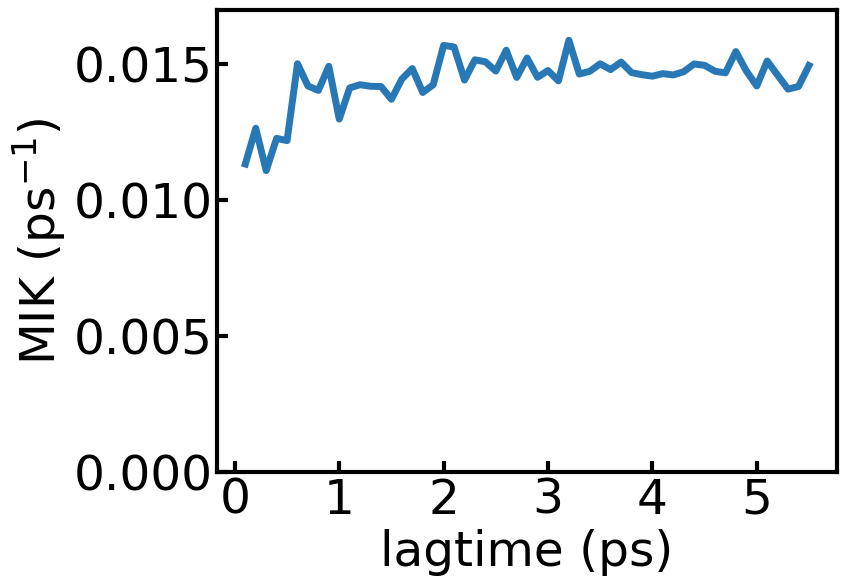

In [12]:
# @title Compute Mean Integeral Kernel (MIK) from qMSM
qmsm = QuasiMSM()
lagtime = np.arange(1, 56) * delta_t
qmsm.fit(TPM, tau_k=55, delta_t=delta_t, rmse=False)

# plot MIK
plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM', zorder=1)
plt.plot([], [], color='#C82423', linewidth=5, label='IGME', linestyle='--',)
plt.ylim(0, 0.017)
plt.xlabel('lagtime (ps)')
plt.ylabel('MIK (ps$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
ax.set_xticks(ticks=[0,1,2,3,4,5])
for spine in ax.spines.values():
    spine.set_linewidth(3)
plt.show()

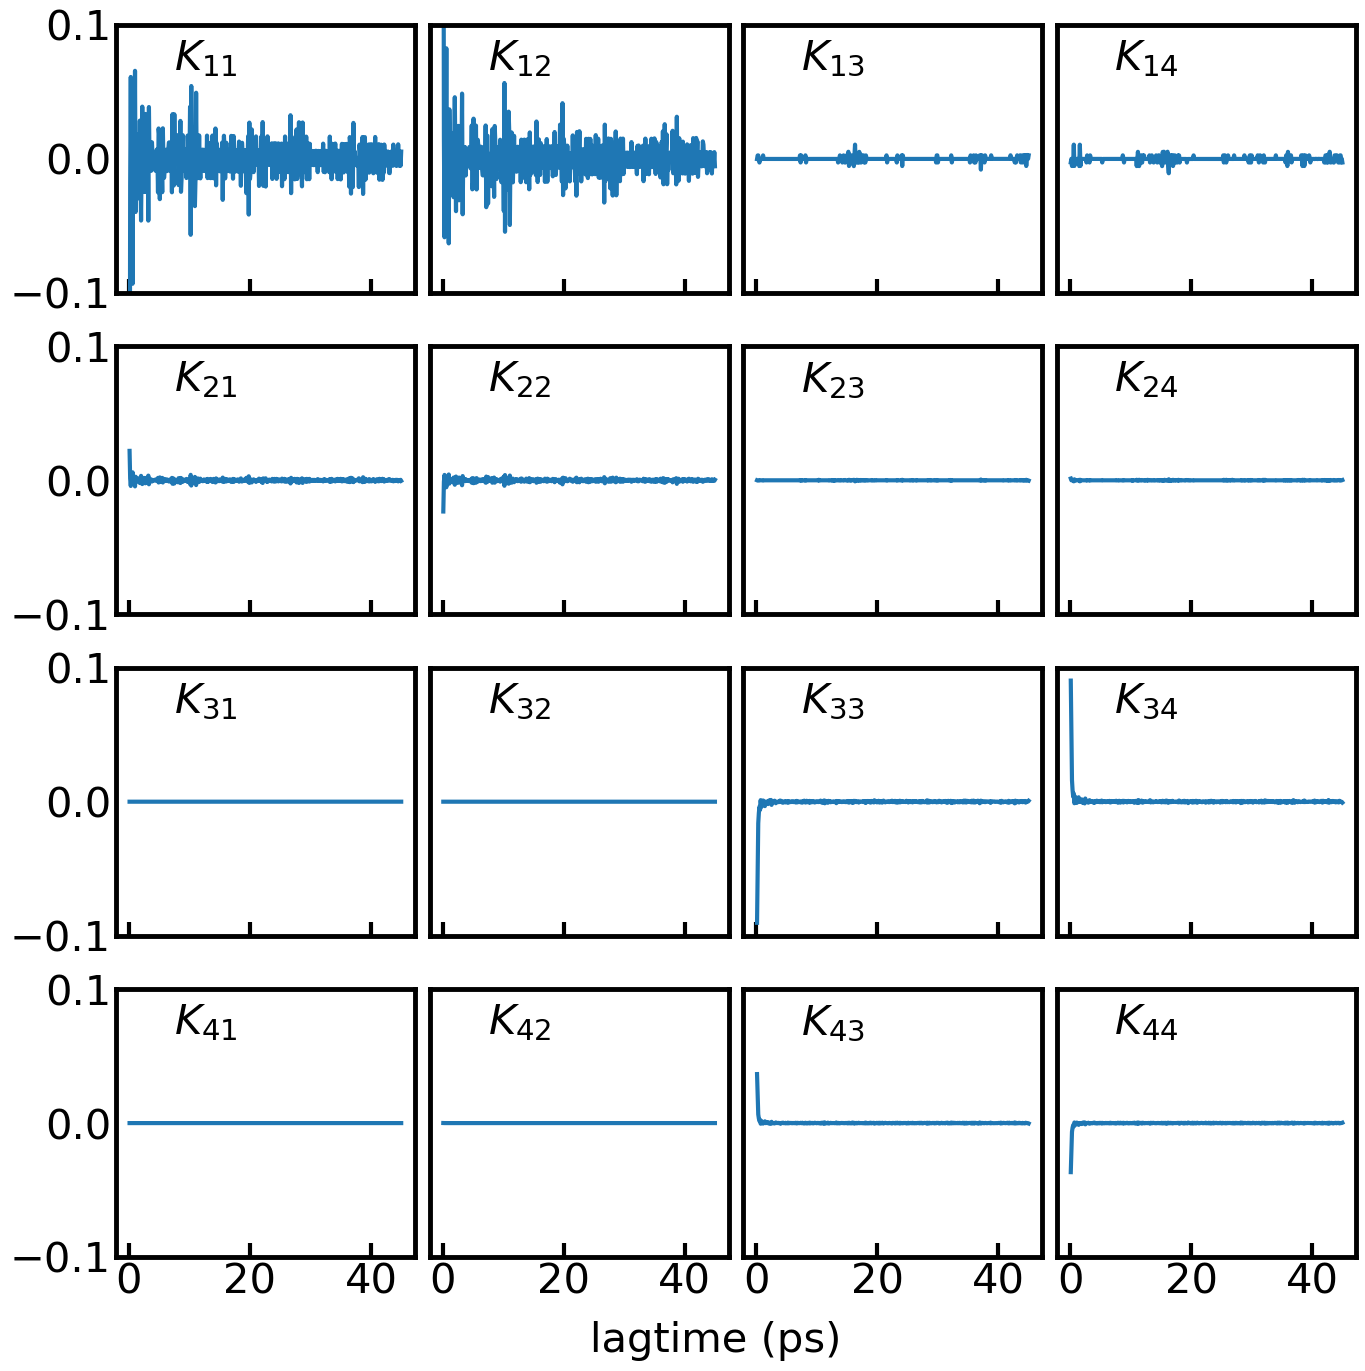

In [13]:
# K(t)
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=450, delta_t=0.1, rmse=False)

plt.rcParams['font.size'] = 30
fig, axes = plt.subplots(4,4,figsize=(16,16), sharex=True, sharey=True)
for i in range(4):
    for j in range(4):
        ax = axes[i,j]
        ax.plot(np.arange(1, 451, 1)*delta_t, qmsm.K[:,i,j], linewidth=3)
        ax.set_ylim(-0.1,0.1)
        ax.tick_params(axis='x', direction='in', width=3, length=10)
        ax.tick_params(axis='y', direction='in', width=0, length=0)
        ax.set_xticks(ticks=[0,20,40], labels=[0,20,40])
        ax.text(18, 0.09, '$K_{{{}{}}}$'.format(i+1, j+1), ha='right',va='top')
        for spine in ax.spines.values():
            spine.set_linewidth(3.5)
plt.subplots_adjust(wspace=0.05, hspace=0.2)
fig.text(0.5, 0.07, 'lagtime (ps)', ha='center', va='top')
plt.show()

In [14]:
# @title Build qMSM
qmsm = QuasiMSM()
qmsm.fit(TPM, tau_k=15, delta_t=delta_t)
qmsm_time, qmsm_tpm = qmsm.predict(TPM) # Use qMSM for prediction
qmsm_rmse = qmsm.rmse # RMSE list of the qMSM models with tau_k from 1 to 15 (* 0.1 ps)
qmsm_its = qmsm.timescales(TPM, ITS_t=100) # ITS predicted by qMSM

In [15]:
# @title Build IGME

# Scan tau_k and L
igme = IGME()
scan_output = igme.scan(input_data=TPM, begin=1, end=16)

# Build top IGME
igme_top = igme.top_model(scan_output, n=1) # Select the top IGME model
igme_tpm = np.array(igme_top.predict(1,len(TPM))) # Use IGME for prediction
igme_top_rmse = igme_top.rmse # RMSE of the top IGME model
igme_mik = igme_top.mik[1] / delta_t
igme_its = igme_top.timescales * delta_t # ITS predicted by top IGME

In [17]:
# @title Build macrostate-MSM
msm = MSM()
tau = np.arange(1, 101)
msm_rmse = msm.scan(TPM, delta_t=0.1, tau_lst=tau, rmse_weighted_by_sp=True)

# Build 1.5 ps MSM
msm_0 = MSM()
msm_0.fit(TPM, tau=15, delta_t = 0.1, rmse=True)
msm_time_0, msm_tpm_0 = msm_0.predict(end=500, add_iden_mat=True)

# Build 10 ps MSM
msm_1 = MSM()
msm_1.fit(TPM, tau=100, delta_t = 0.1, rmse=True)
msm_time_1, msm_tpm_1 = msm_1.predict(end=500, add_iden_mat=True)

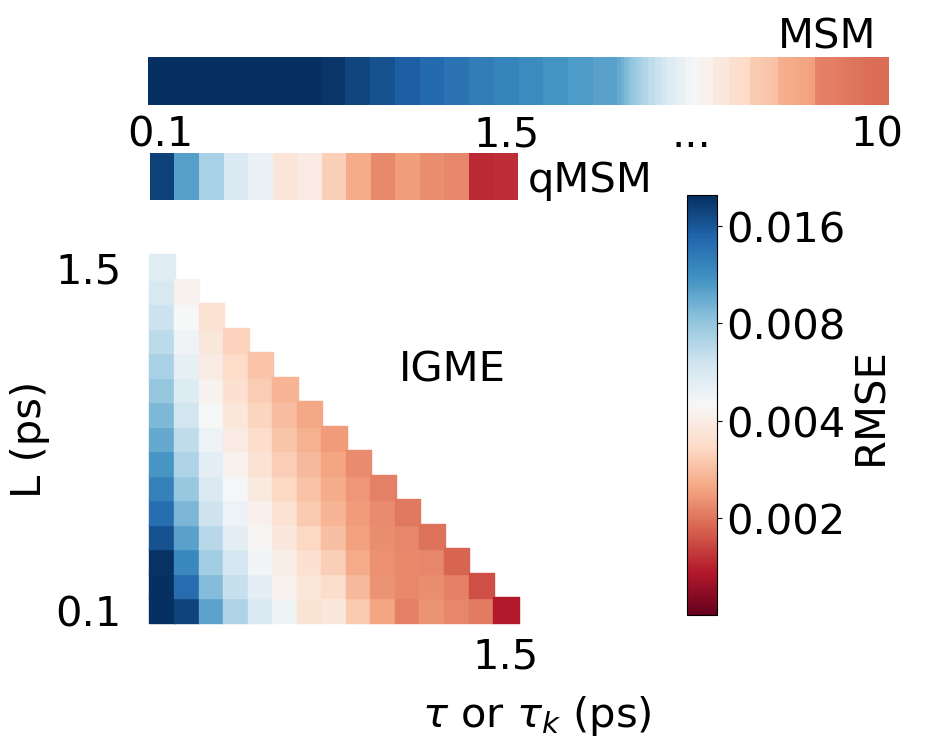

In [15]:
# @title Plot RMSE map

from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
x = [i * 0.1 for i in scan_output['begin']]
y = [(scan_output['end'][i] - scan_output['begin'][i]) * 0.1 for i in range(len(x))]
z = scan_output['rmse']

cmap_name = 'RdBu'  # You can use any colormap of your choice from Matplotlib's colormaps
custom_cmap = plt.get_cmap(cmap_name)
norm = mcolors.LogNorm(vmin=1e-3, vmax=2e-2)

def adjust_tau(x):
    if x < 20:
        return x/10
    else:
        return x/80 + 1.75

plt.rcParams['font.size'] = 30
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True,
                         gridspec_kw={'height_ratios': [1, 4]})

lagtime = np.arange(1, 16, 1)
qmsm_color_bar = custom_cmap(norm(qmsm_rmse))
upper_bound = np.ones(len(lagtime))*0.5
axes[0].bar(lagtime*0.1, upper_bound, color=qmsm_color_bar, width=0.1)
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].set_ylim(-0.5, 0.5)
axes[0].text(2.1, 0, 'qMSM', ha='right', va='bottom')
axes[0].set_frame_on(False)
axes[0].tick_params(left=False, right=False, bottom=False, top=False)

axes[1].scatter(x, y, c=z, cmap=custom_cmap, norm=norm, marker='s', s=335 )
axes[1].set_frame_on(False)
axes[1].tick_params(left=False, right=False, bottom=False, top=False)
axes[1].set_xticks([1.5])
axes[1].set_yticks([0.1, 1.5])
axes[1].text(1.5, 1, 'IGME', ha='right', va='bottom')
fig.text(0.8, 0, '$\\tau$ or $ \\tau_k $ (ps)', ha='center', va='top')
axes[1].set_ylabel('L (ps)')

plt.subplots_adjust(hspace=0.01)
fig.subplots_adjust(top=0.9)
msm_ax = fig.add_axes([0.09, 0.98, 1.36, 0.16])
upper_bound = np.ones(len(tau))*0.5
msm_color_bar = custom_cmap(norm(msm_rmse))
msm_ax.bar([adjust_tau(i) for i in tau], upper_bound, color=msm_color_bar, width=0.1)
msm_ax.set_yticks([])
msm_ax.set_xticks([])
msm_ax.set_ylim(0, 1)
msm_ax.set_xticks([0.1, 1.5, 2.25, 3], labels=[0.1, 1.5, "...", 10])
msm_ax.text(2.6,0.6,'MSM')
msm_ax.set_frame_on(False)
msm_ax.tick_params(left=False, right=False, bottom=False, top=False)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([1.05, 0.13, 0.05, 0.7])
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=custom_cmap), cax=cbar_ax)
# ticks = [1e-2, 2e-2, 4e-2, 8e-2, 1.6e-1]
ticks = [2e-3, 4e-3, 8e-3, 1.6e-2]
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticks)
cbar.ax.minorticks_off()
cbar.set_label('RMSE')
plt.show()

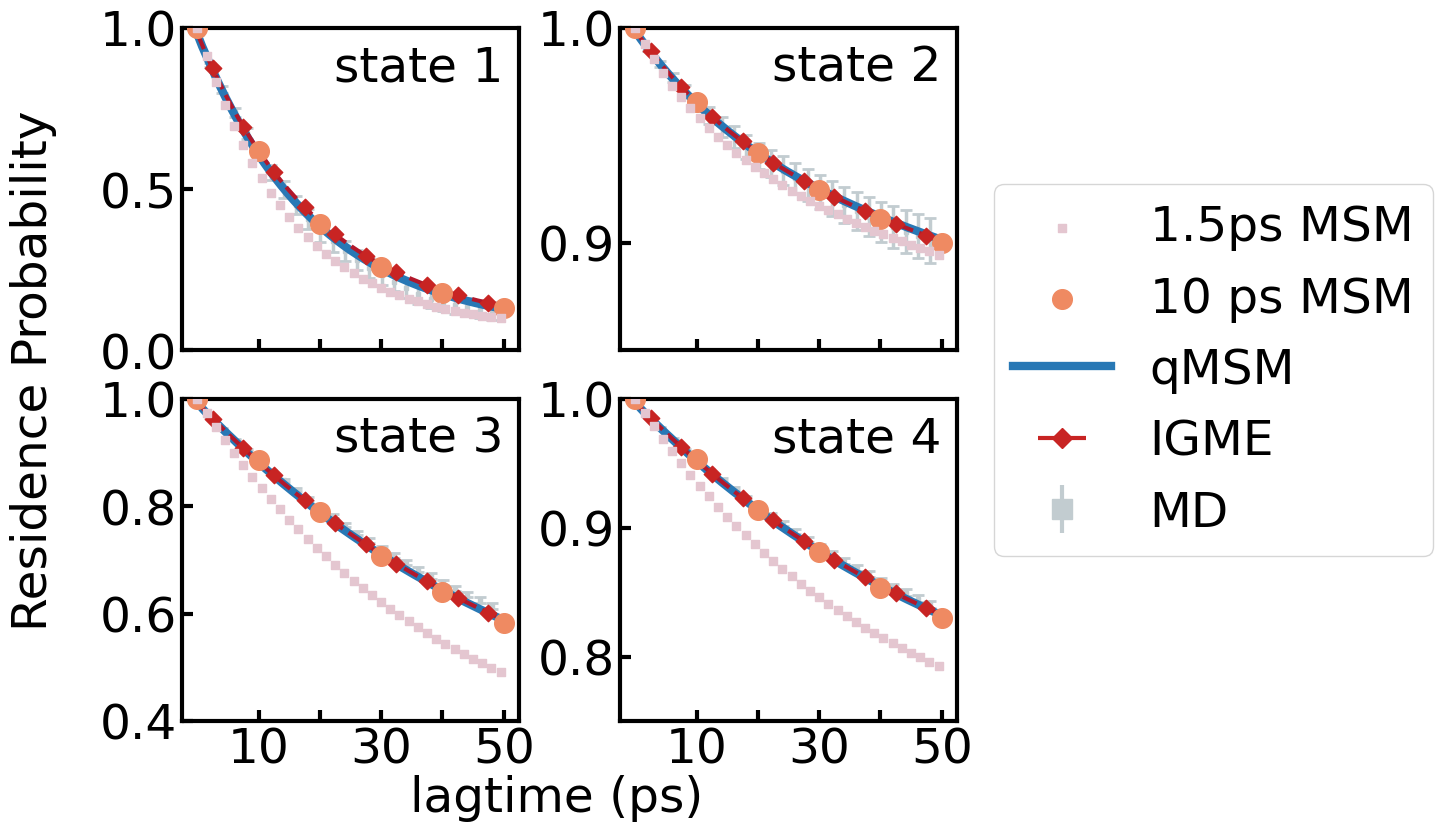

In [18]:
# @title CK test
length = 500
lt = np.arange(1,length+1) * delta_t
n_state = 4
plt.rcParams['font.size'] = 35
bottom = [0.02, 0.85, 0.4, 0.75]

TPM_mean = np.mean(bootstrap_TPM, axis=0)
TPM_std = np.std(bootstrap_TPM, axis=0)
fig, axes = plt.subplots(2,2,figsize=(10,9), sharex=True)

for i in range(n_state):
    ax = axes[i//2, i-(i//2)*2]
#     ax.fill_between(lt, TPM_mean[:length,i,i]-TPM_std[:length,i,i],
#                     TPM_mean[:length,i,i]+TPM_std[:length,i,i], color='#fff2df', zorder=0)
    ax.errorbar(x=lt[:length:20], y=TPM_mean[:length:20,i,i], yerr=TPM_std[:length:20,i,i],
                fmt='s', capsize=4, capthick=2, elinewidth=2.5, markersize=3,
                ecolor='#c2ccd0', color='#c2ccd0',
                zorder=0)
    ax.plot(qmsm_time[:length], qmsm_tpm[:length,i,i], color='#2878B5', linewidth=6, zorder=2)
    ax.plot(lt, igme_tpm[:length,i,i], color='#b2182b', linewidth=3, zorder=3, linestyle='--')
    ax.scatter(lt[24::50], igme_tpm[24:length:50,i,i], c='#C82423', marker='D', s=70, zorder=3)
    ax.scatter(msm_time_1, msm_tpm_1[:,i,i], c='#ef8a62', s=200, zorder=4)
    ax.scatter(msm_time_0, msm_tpm_0[:,i,i], c='#e4c6d0', s=40, marker='s', zorder=4)

    ax.set_ylim(bottom[i],1.0)
    ax.text(50, 0.95+0.05*bottom[i], 'state %d'%(i+1), ha='right',va='top')
    ax.tick_params(axis='both', direction='in', width=3, length=8)
    ax.set_xticks(ticks=[10,20,30,40,50], labels=[10,'',30,'',50])
    for spine in ax.spines.values():
        spine.set_linewidth(3)

axes[0, 0].set_ylim(0,1.0)
axes[0, 1].set_ylim(0.85,1.0)
axes[1, 0].set_ylim(0.4,1.0)
axes[1, 1].set_ylim(0.75,1.0)

plt.scatter([], [], c='#e4c6d0', s=40, marker='s', label='1.5ps MSM')
plt.scatter([], [], c='#ef8a62', s=200, label='10 ps MSM')
plt.plot([], [], label='qMSM', color='#2878B5', linewidth=6)
plt.errorbar([], [], xerr=[], color='#C82423', label='IGME', fmt='D',
             markersize=10, elinewidth=3, capsize=3)
plt.errorbar([], [], yerr=[], color='#c2ccd0', label='MD', fmt='s',
             markersize=15, elinewidth=3, capsize=3)
fig.text(0.5, 0.05, 'lagtime (ps)', ha='center', va='top')
fig.text(0, 0.5, "Residence Probability", ha='right', va='center', rotation=90)
fig.legend(loc='center right', bbox_to_anchor=(1.4, 0.5))
plt.subplots_adjust(wspace=0.3, hspace=0.15)
plt.show()

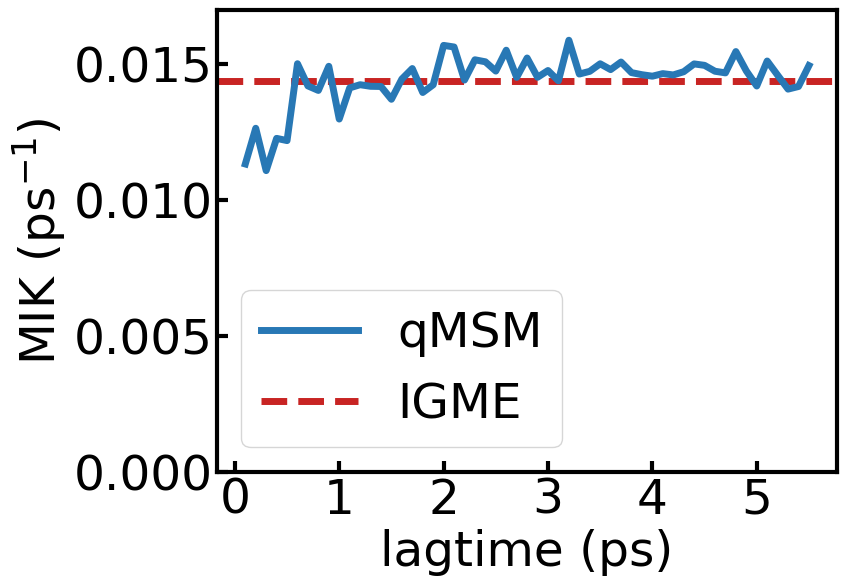

In [19]:
# @title MIK computed from qMSM and IGME
qmsm = QuasiMSM()
lagtime = np.arange(1, 56) * delta_t
qmsm.fit(TPM, tau_k=55, delta_t=delta_t, rmse=False)

# plot MIK
plt.rcParams['font.size'] = 35
fig, ax = plt.subplots(figsize=(8,6))
plt.axhline(y=igme_top.mik[1]/ delta_t, color='#C82423', linestyle='--', linewidth=5, zorder=0)
plt.plot(lagtime, qmsm.mik, color='#2878B5', linewidth=5, label='qMSM', zorder=1)
plt.plot([], [], color='#C82423', linewidth=5, label='IGME', linestyle='--',)
plt.ylim(0, 0.017)
plt.xlabel('lagtime (ps)')
plt.ylabel('MIK (ps$^{-1}$)')
ax.tick_params(axis='both', direction='in', width=3, length=8)
ax.set_xticks(ticks=[0,1,2,3,4,5])
for spine in ax.spines.values():
    spine.set_linewidth(3)
plt.legend()
plt.show()

In [20]:
# @title The timescales
print("Implied Timescales of 1.5 ps MSM:")
print(msm_0.timescales)

print("\nImplied Timescales of 10 ps MSM:")
print(msm_1.timescales)

print("\nImplied Timescales of qMSM at 100 ps:")
print(qmsm_its)

print("\nImplied Timescales of IGME:")
print(igme_its)

Implied Timescales of 1.5 ps MSM:
[1053.65197756   39.49202616   15.19822643]

Implied Timescales of 10 ps MSM:
[1131.7070932    56.77191266   19.14247057]

Implied Timescales of qMSM at 100 ps:
[1137.35416238   54.63913391   18.37283236]

Implied Timescales of IGME:
[1152.34228218   58.67294117   19.83555078]


In [21]:
# @title RMSE
print("RMSE of 1.5 ps MSM:")
print(msm_0.rmse)

print("\nRMSE of 10 ps MSM:")
print(msm_1.rmse)

print("\nRMSE of qMSM:")
print(qmsm_rmse[-1])

print("\nRMSE of IGME:")
print(igme_top_rmse)

RMSE of 1.5 ps MSM:
0.012185450387275564

RMSE of 10 ps MSM:
0.0019461125933943632

RMSE of qMSM:
0.0014813581427672148

RMSE of IGME:
0.0013669837427414246
